In [1]:
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [1]:
from processing_functions import create_df
start_date = "2023-03-24 12:00"
end_date = "2025-02-10 10:00"
df_main = create_df(timeFramesUsedInMinutes=["1","5", "15"], instrument="ES", 
                    start_date = start_date, end_date = end_date, putVolumeInData=False) 

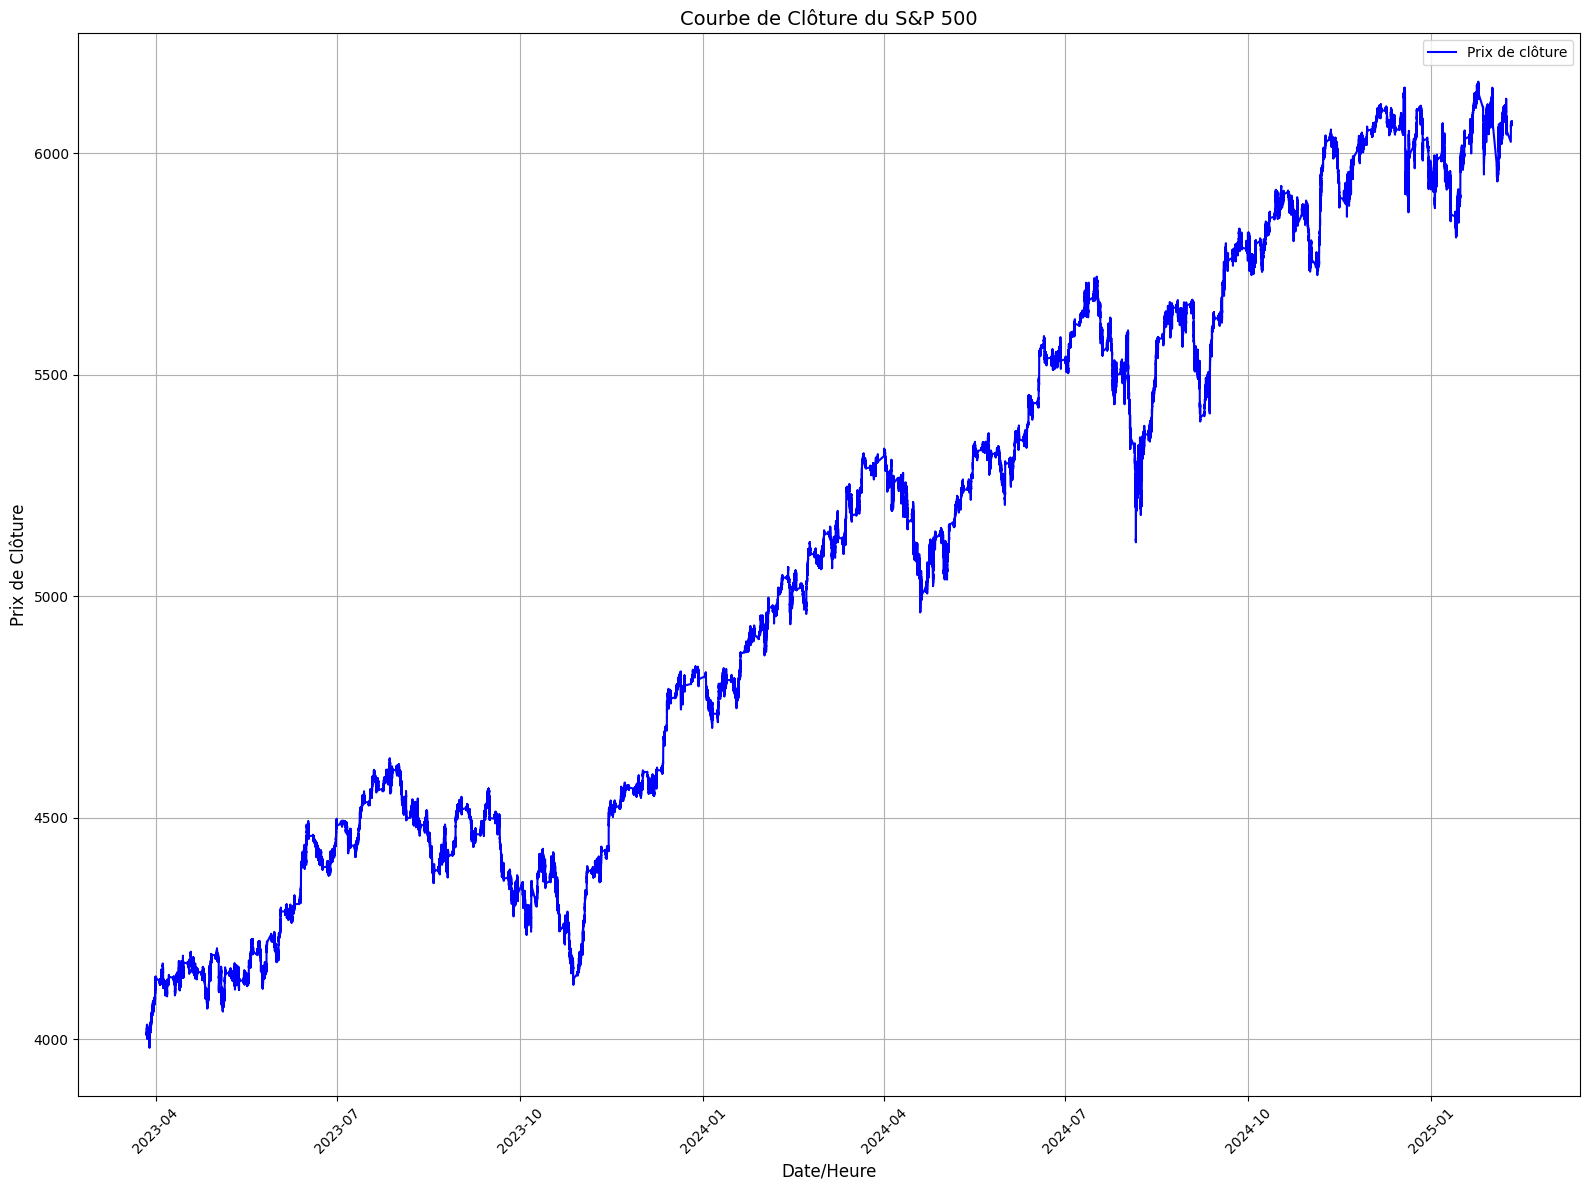

In [4]:

import matplotlib.pyplot as plt 
plt.figure(figsize=(16,12))
plt.plot(df_main['datetime'], df_main['close'], label='Prix de clôture', color='b')
plt.title('Courbe de Clôture du S&P 500', fontsize=14)
plt.xlabel('Date/Heure', fontsize=12)
plt.ylabel('Prix de Clôture', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

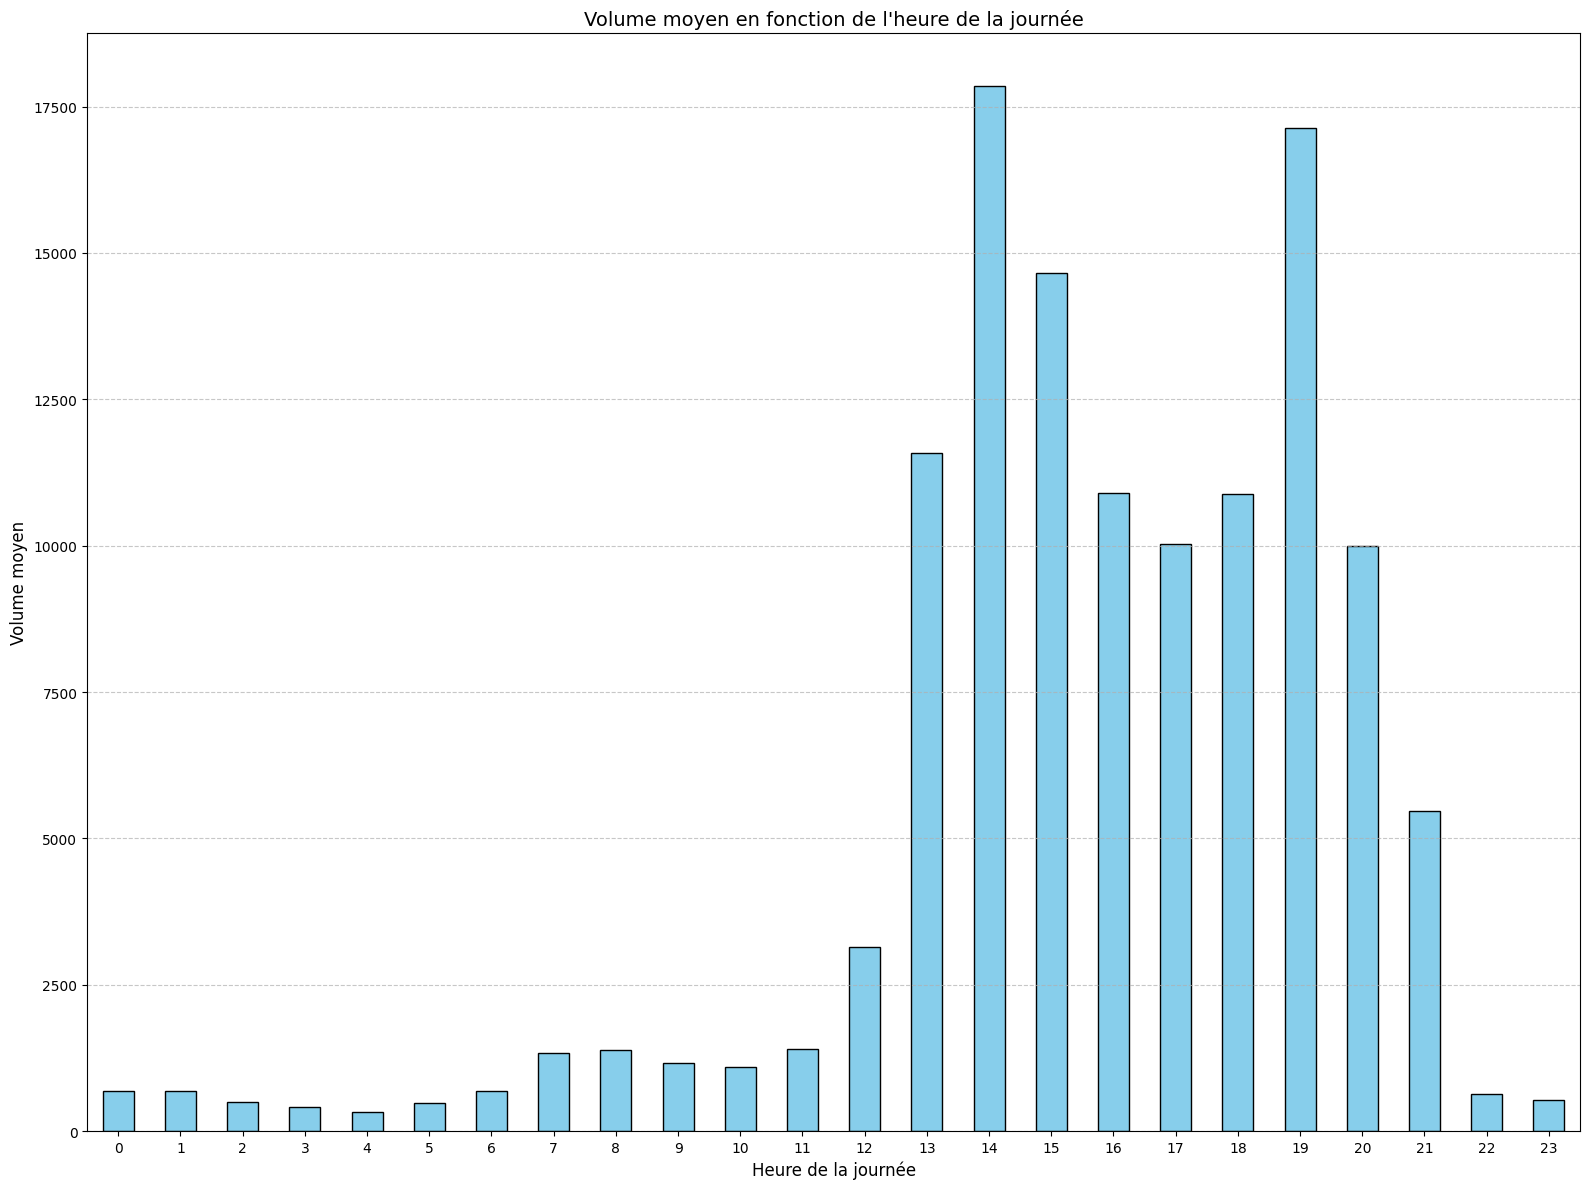

In [3]:
import matplotlib.pyplot as plt 

# Extraire l'heure de la journée à partir de 'timestamp'
df_main['hour'] = df_main['datetime'].dt.hour

# Calculer le volume moyen pour chaque heure
volume_moyen_par_heure = df_main.groupby('hour')['volume'].mean()

# Affichage des résultats sous forme d'histogramme
plt.figure(figsize=(16, 12))
volume_moyen_par_heure.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Volume moyen en fonction de l\'heure de la journée', fontsize=14)
plt.xlabel('Heure de la journée', fontsize=12)
plt.ylabel('Volume moyen', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher l'histogramme
plt.tight_layout()
plt.show()

### TRY WITH US CALENDAR EVENTS ###

In [12]:
from processing_functions import return_trade_datas_dataframe

filename = 'result_file'
filepath = f"ES/2023-03-24_12-00_2025-02-10_10-00/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated.tail(5)

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,bracketsModifier,percentHitToMoveTP,tpToMoveInTicks,nbrTimeMaxMoveTP,stopMethodsForKijunExitExit,"maxLossStreak, avgLossStreak"
155,76.244,68.92,66.64,0.510,-1.282,0.40,"(613, 191, 1)",20.5,51.4,"(55, 25, 55, 60)",0 days 00:40:00,0 days 02:10:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(11, 2.77)"
123,75.577,70.92,68.58,0.503,-1.211,0.42,"(622, 201, 1)",20.2,48.5,"(50, 25, 60, 55)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(15, 2.72)"
125,75.589,71.32,69.03,0.506,-1.210,0.42,"(610, 197, 1)",20.4,48.5,"(50, 25, 60, 60)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(14, 2.76)"
117,75.303,71.93,69.58,0.505,-1.191,0.42,"(622, 204, 1)",20.3,47.8,"(50, 25, 55, 55)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(10, 2.67)"
119,75.309,72.50,70.20,0.508,-1.192,0.43,"(610, 200, 1)",20.4,47.8,"(50, 25, 55, 60)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(10, 2.71)"


In [ ]:
from processing_functions import return_trade_datas_dataframe
filename = 'result_file51560'
filepath = f"ES/2023-03-24_12-00_2025-02-10_10-00/{filename}.pkl"
tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated.tail(5) # only > or < SSB in high TF

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,bracketsModifier,percentHitToMoveTP,tpToMoveInTicks,nbrTimeMaxMoveTP,stopMethodsForKijunExitExit,"maxLossStreak, avgLossStreak"
1,61.920,68.85,67.01,0.855,-1.113,0.77,"(400, 246, 1)",34.3,44.6,"(50, 25, 55, 60)",0 days 01:10:00,0 days 03:02:30,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,0,"(7, 1.91)"
28,76.429,69.68,67.68,0.518,-1.263,0.41,"(535, 165, 1)",20.9,50.7,"(55, 25, 55, 60)",0 days 00:40:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(19, 2.72)"
13,62.166,70.49,68.68,0.855,-1.115,0.77,"(396, 241, 1)",34.3,44.7,"(50, 25, 55, 65)",0 days 01:12:30,0 days 03:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,0,"(7, 1.92)"
16,75.793,72.42,70.45,0.515,-1.185,0.44,"(526, 168, 1)",20.7,47.6,"(50, 25, 55, 65)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(13, 2.64)"
4,75.641,73.70,71.70,0.517,-1.178,0.44,"(531, 171, 1)",20.8,47.3,"(50, 25, 55, 60)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(13, 2.66)"


In [1]:
from processing_functions import return_trade_datas_dataframe
filename = 'result_file_5m_2025-03-25_17-23-57.565385'
filepath = f"ES/2023-03-24_12-00_2025-02-10_10-00/{filename}.pkl"
tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated # only SSB check in high TF + moveSL only when TP moved

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,bracketsModifier,percentHitToMoveTP,tpToMoveInTicks,nbrTimeMaxMoveTP,stopMethod,"maxLossStreak, avgLossStreak",calendar_event
39,63.846,46.20,40.53,0.751,-1.148,0.66,"(415, 235, 1)",30.4,45.8,"(50, 25, 55, 65)",0 days 01:05:00,0 days 02:45:00,"[5, 15, 60]","[[0.6, -0.5], [0.9, 0.2]]",0.40,13,2,0,"(8, 1.9)",[]
40,63.441,46.88,41.19,0.746,-1.116,0.68,"(413, 238, 1)",30.2,44.5,"(50, 25, 55, 65)",0 days 01:02:30,0 days 02:41:15,"[5, 15, 60]","[[0.6, -0.4], [0.7, -0.2], [0.9, 0.25]]",0.40,13,2,0,"(8, 1.93)",[]
33,63.957,47.96,42.26,0.751,-1.148,0.66,"(417, 235, 1)",30.4,45.8,"(50, 25, 55, 65)",0 days 01:05:00,0 days 02:45:00,"[5, 15, 60]","[[0.6, -0.5], [0.9, 0.2]]",0.40,12,2,0,"(8, 1.91)",[]
42,63.692,48.07,42.40,0.752,-1.135,0.67,"(414, 236, 1)",30.4,45.3,"(50, 25, 55, 65)",0 days 01:00:00,0 days 02:42:30,"[5, 15, 60]","[[0.6, -0.5], [0.75, -0.2], [0.9, 0.3]]",0.40,13,2,0,"(8, 1.92)",[]
27,64.110,49.13,43.43,0.746,-1.142,0.66,"(418, 234, 1)",30.2,45.5,"(50, 25, 55, 65)",0 days 01:00:00,0 days 02:40:00,"[5, 15, 60]","[[0.6, -0.5], [0.9, 0.2]]",0.40,11,2,0,"(8, 1.89)",[]
46,63.538,49.69,44.02,0.750,-1.117,0.68,"(413, 237, 1)",30.4,44.5,"(50, 25, 55, 65)",0 days 01:05:00,0 days 02:45:00,"[5, 15, 60]","[[0.6, -0.4], [0.7, -0.2], [0.9, 0.25]]",0.40,14,2,0,"(7, 1.94)",[]
21,65.184,50.27,44.57,0.729,-1.164,0.64,"(425, 227, 1)",29.5,46.4,"(50, 25, 55, 65)",0 days 01:00:00,0 days 02:40:00,"[5, 15, 60]","[[0.6, -0.5], [0.9, 0.2]]",0.55,14,2,0,"(8, 1.91)",[]
34,63.706,50.33,44.63,0.747,-1.119,0.68,"(416, 237, 1)",30.2,44.6,"(50, 25, 55, 65)",0 days 01:02:30,0 days 02:40:00,"[5, 15, 60]","[[0.6, -0.4], [0.7, -0.2], [0.9, 0.25]]",0.40,12,2,0,"(8, 1.92)",[]
22,64.877,50.41,44.71,0.727,-1.143,0.65,"(423, 229, 1)",29.4,45.6,"(50, 25, 55, 65)",0 days 01:00:00,0 days 02:40:00,"[5, 15, 60]","[[0.6, -0.4], [0.7, -0.2], [0.9, 0.25]]",0.55,14,2,0,"(8, 1.95)",[]
35,63.190,50.45,44.76,0.756,-1.107,0.69,"(412, 240, 1)",30.6,44.1,"(50, 25, 55, 65)",0 days 01:00:00,0 days 02:40:00,"[5, 15, 60]","[[0.6, -0.5], [0.7, -0.1], [0.95, 0.45]]",0.40,12,2,0,"(6, 1.91)",[]


In [10]:
from processing_functions import describe_daily_and_weekly_trade_datas
describe_daily_and_weekly_trade_datas(filepath, selected_Id=780)


      profit_including_fees_from_start(%)
                                      sum
count                          681.000000
mean                             0.060308
std                              1.010307
min                             -4.814200
25%                              0.000000
50%                              0.000000
75%                              0.622160
max                              4.299440 
       profit_including_fees_from_start(%)
                                      sum
count                           98.000000
mean                             0.419077
std                              2.698706
min                             -7.509080
25%                             -1.072860
50%                              0.566200
75%                              2.527710
max                              6.896600


In [1]:
from processing_functions import return_trade_datas_dataframe

filename = 'result_file_1m_2025-03-25_10-03-15.002078'
filepath = f"ES/2023-03-24_12-00_2025-02-10_10-00/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,bracketsModifier,percentHitToMoveTP,tpToMoveInTicks,nbrTimeMaxMoveTP,stopMethod,"maxLossStreak, avgLossStreak",calendar_event
12,38.492,-100.66,-221.17,0.248,-0.171,1.48,"(5111, 8167, 542)",10.3,6.9,"(50, 25, 55, 65)",0 days 00:03:50,0 days 00:07:30,"[1, 5, 15]","[[0.6, -0.5], [0.75, -0.2], [0.9, 0.3]]",0.55,12,2,2,"(45, 3.58)",[]
16,38.468,-99.56,-220.10,0.248,-0.171,1.49,"(5109, 8172, 542)",10.3,6.9,"(50, 25, 55, 65)",0 days 00:03:50,0 days 00:07:30,"[1, 5, 15]","[[0.6, -0.5], [0.75, -0.2], [0.9, 0.3]]",0.60,12,2,2,"(45, 3.58)",[]
10,38.492,-97.64,-218.15,0.248,-0.171,1.49,"(5111, 8167, 542)",10.3,6.9,"(50, 25, 55, 65)",0 days 00:03:50,0 days 00:07:30,"[1, 5, 15]","[[0.6, -0.5], [0.75, -0.2], [0.9, 0.3]]",0.55,11,2,2,"(45, 3.58)",[]
11,38.564,-97.14,-217.62,0.248,-0.171,1.48,"(5119, 8155, 543)",10.3,6.9,"(50, 25, 55, 65)",0 days 00:03:50,0 days 00:07:30,"[1, 5, 15]","[[0.6, -0.5]]",0.55,12,2,2,"(45, 3.59)",[]
14,38.459,-97.03,-217.55,0.249,-0.171,1.49,"(5107, 8172, 542)",10.3,6.9,"(50, 25, 55, 65)",0 days 00:03:50,0 days 00:07:30,"[1, 5, 15]","[[0.6, -0.5], [0.75, -0.2], [0.9, 0.3]]",0.60,11,2,2,"(45, 3.58)",[]
15,38.555,-95.19,-215.70,0.248,-0.171,1.49,"(5119, 8158, 543)",10.3,6.9,"(50, 25, 55, 65)",0 days 00:03:50,0 days 00:07:30,"[1, 5, 15]","[[0.6, -0.5]]",0.60,12,2,2,"(45, 3.59)",[]
9,38.564,-94.24,-214.72,0.248,-0.171,1.49,"(5119, 8155, 543)",10.3,6.9,"(50, 25, 55, 65)",0 days 00:03:50,0 days 00:07:30,"[1, 5, 15]","[[0.6, -0.5]]",0.55,11,2,2,"(45, 3.59)",[]
13,38.546,-92.79,-213.28,0.249,-0.171,1.49,"(5117, 8158, 543)",10.3,6.9,"(50, 25, 55, 65)",0 days 00:03:50,0 days 00:07:30,"[1, 5, 15]","[[0.6, -0.5]]",0.60,11,2,2,"(45, 3.59)",[]
18,89.206,19.78,-58.75,0.143,-1.239,0.12,"(8033, 972, 1)",6.1,49.3,"(50, 25, 55, 65)",0 days 00:05:50,0 days 00:16:07.500000,"[1, 5, 15]","[[0.6, -0.5], [0.75, -0.2], [0.9, 0.3]]",0.55,11,2,4,"(42, 4.71)",[]
17,89.254,20.50,-57.98,0.143,-1.246,0.12,"(8032, 967, 1)",6.1,49.5,"(50, 25, 55, 65)",0 days 00:05:50,0 days 00:16:10,"[1, 5, 15]","[[0.6, -0.5]]",0.55,11,2,4,"(42, 4.73)",[]


In [ ]:
from processing_functions import return_trade_datas_dataframe

filename = 'result_file_1m_2025-03-25_11-23-03.360828'
filepath = f"ES/2023-03-24_12-00_2025-02-10_10-00/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated #with only SSB on higher tf

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,bracketsModifier,percentHitToMoveTP,tpToMoveInTicks,nbrTimeMaxMoveTP,stopMethod,"maxLossStreak, avgLossStreak",calendar_event
7,54.142,41.91,12.61,0.891,-1.041,0.87,"(1817, 1539, 4)",36.0,41.4,"(50, 25, 55, 65)",0 days 00:55:45,0 days 02:11:42.500000,"[1, 15]","[[0.6, -0.5]]",0.55,12,2,0,"(14, 1.96)",[]
1,54.219,48.14,18.75,0.891,-1.040,0.87,"(1825, 1541, 4)",36.0,41.4,"(50, 25, 55, 65)",0 days 00:55:00,0 days 02:11:40,"[1, 15]","[[0.6, -0.5]]",0.55,11,2,0,"(14, 1.96)",[]
9,57.014,51.83,21.84,0.818,-1.067,0.78,"(1959, 1477, 4)",33.1,42.5,"(50, 25, 55, 65)",0 days 00:53:20,0 days 02:07:12.500000,"[1, 15]","[[0.6, -0.5], [0.9, 0.2]]",0.55,12,2,0,"(14, 2.01)",[]
11,53.685,53.35,22.45,0.826,-0.942,0.89,"(1901, 1640, 3)",33.4,37.4,"(50, 25, 55, 65)",0 days 00:51:30,0 days 02:02:30,"[1, 15]","[[0.6, -0.5], [0.75, -0.2], [0.9, 0.3]]",0.55,12,2,0,"(11, 1.93)",[]
3,56.944,54.83,24.71,0.818,-1.062,0.78,"(1964, 1485, 4)",33.1,42.3,"(50, 25, 55, 65)",0 days 00:53:10,0 days 02:06:50,"[1, 15]","[[0.6, -0.5], [0.9, 0.2]]",0.55,11,2,0,"(14, 2.01)",[]
5,53.755,59.76,28.85,0.828,-0.943,0.89,"(1904, 1638, 3)",33.5,37.4,"(50, 25, 55, 65)",0 days 00:51:30,0 days 02:02:40,"[1, 15]","[[0.6, -0.5], [0.75, -0.2], [0.9, 0.3]]",0.55,11,2,0,"(11, 1.93)",[]
6,54.035,111.34,83.97,0.840,-0.928,0.92,"(1694, 1441, 3)",34.0,36.8,"(50, 25, 55, 65)",0 days 00:52:15,0 days 02:02:47.500000,"[1, 5, 15]","[[0.6, -0.5], [0.75, -0.2], [0.9, 0.3]]",0.55,11,2,0,"(10, 1.92)",[]
4,57.388,111.97,85.50,0.833,-1.052,0.80,"(1740, 1292, 4)",33.7,41.9,"(50, 25, 55, 65)",0 days 00:54:20,0 days 02:09:12.500000,"[1, 5, 15]","[[0.6, -0.5], [0.9, 0.2]]",0.55,11,2,0,"(14, 2.02)",[]
2,54.831,115.69,89.84,0.906,-1.029,0.89,"(1623, 1337, 4)",36.6,40.9,"(50, 25, 55, 65)",0 days 00:56:40,0 days 02:15:00,"[1, 5, 15]","[[0.6, -0.5]]",0.55,11,2,0,"(14, 1.96)",[]
12,54.220,120.34,93.04,0.840,-0.928,0.92,"(1696, 1432, 3)",34.0,36.9,"(50, 25, 55, 65)",0 days 00:52:30,0 days 02:02:50,"[1, 5, 15]","[[0.6, -0.5], [0.75, -0.2], [0.9, 0.3]]",0.55,12,2,0,"(10, 1.92)",[]


In [2]:
from processing_functions import return_trade_datas_dataframe

filename = 'result_file_1m_2025-03-25_13-58-16.276497'
filepath = f"ES/2023-03-24_12-00_2025-02-10_10-00/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated.tail(5) #with only SSB on higher tf

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,bracketsModifier,percentHitToMoveTP,tpToMoveInTicks,nbrTimeMaxMoveTP,stopMethod,"maxLossStreak, avgLossStreak",calendar_event
22,51.791,117.56,89.54,0.836,-0.839,1.02,"(1663, 1548, 3)",33.8,33.3,"(50, 25, 50, 65)",0 days 00:50:15,0 days 01:58:25,"[1, 5, 15]","[[0.6, -0.4], [0.7, -0.2], [0.9, 0.25]]",0.55,12,2,0,"(10, 1.89)",[]
5,50.361,117.71,89.91,0.869,-0.823,1.08,"(1604, 1581, 3)",35.1,32.6,"(50, 25, 55, 65)",0 days 00:50:50,0 days 02:01:42.500000,"[1, 5, 15]","[[0.6, -0.5], [0.7, -0.1], [0.95, 0.45]]",0.55,11,2,0,"(10, 1.87)",[]
18,54.220,120.34,93.04,0.840,-0.928,0.92,"(1696, 1432, 3)",34.0,36.9,"(50, 25, 55, 65)",0 days 00:52:30,0 days 02:02:50,"[1, 5, 15]","[[0.6, -0.5], [0.75, -0.2], [0.9, 0.3]]",0.55,12,2,0,"(10, 1.92)",[]
24,53.729,120.78,93.27,0.842,-0.912,0.94,"(1693, 1458, 4)",34.0,36.2,"(50, 25, 50, 65)",0 days 00:52:00,0 days 02:00:50,"[1, 5, 15]","[[0.6, -0.5], [0.75, -0.2], [0.9, 0.3]]",0.55,12,2,0,"(10, 1.92)",[]
11,50.031,121.90,93.90,0.870,-0.811,1.09,"(1605, 1603, 3)",35.1,32.1,"(50, 25, 50, 65)",0 days 00:50:20,0 days 02:00:15,"[1, 5, 15]","[[0.6, -0.5], [0.7, -0.1], [0.95, 0.45]]",0.55,11,2,0,"(10, 1.86)",[]


In [ ]:
from processing_functions import return_trade_datas_dataframe

filename = 'result_file_1m_2025-03-25_18-07-44.793163'
filepath = f"ES/2023-03-24_12-00_2025-02-10_10-00/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated.tail(5) # with SSB only on higher timeframe + moveSL after tp moved and tenkan count in tp move func

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,bracketsModifier,percentHitToMoveTP,tpToMoveInTicks,nbrTimeMaxMoveTP,stopMethod,"maxLossStreak, avgLossStreak",calendar_event
13,59.019,146.94,121.67,0.859,-1.131,0.77,"(1708, 1186, 4)",34.7,45.0,"(50, 25, 55, 65)",0 days 00:52:40,0 days 02:32:40,"[1, 5, 15]","[[0.6, -0.5]]",0.55,11,2,0,"(17, 2.37)",[]
15,57.517,148.15,122.12,0.845,-1.043,0.82,"(1714, 1266, 5)",34.1,41.6,"(50, 25, 55, 65)",0 days 00:51:00,0 days 02:26:50,"[1, 5, 15]","[[0.6, -0.5], [0.7, -0.1], [0.95, 0.45]]",0.55,11,2,0,"(17, 2.38)",[]
5,59.415,147.45,122.70,0.862,-1.153,0.76,"(1685, 1151, 3)",34.8,45.9,"(50, 25, 55, 65)",0 days 00:55:00,0 days 02:36:50,"[1, 5, 15]","[[0.6, -0.5], [0.9, 0.2]]",0.35,11,2,0,"(17, 2.38)",[]
14,59.835,148.91,123.48,0.839,-1.141,0.75,"(1743, 1170, 4)",33.9,45.4,"(50, 25, 55, 65)",0 days 00:52:10,0 days 02:30:30,"[1, 5, 15]","[[0.6, -0.5], [0.9, 0.2]]",0.55,11,2,0,"(17, 2.36)",[]
8,59.437,148.64,124.12,0.865,-1.154,0.76,"(1669, 1139, 4)",34.9,46.0,"(50, 25, 55, 65)",0 days 00:55:30,0 days 02:39:55,"[1, 5, 15]","[[0.6, -0.5], [0.9, 0.2]]",0.35,12,2,0,"(17, 2.38)",[]


In [5]:
from processing_functions import return_trade_datas_dataframe

filename = 'result_file_1m_2025-03-25_20-18-11.680621'
filepath = f"ES/2023-03-24_12-00_2025-02-10_10-00/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated.tail(5) # with SSB only on higher timeframe + moveSL after tp moved and tenkan count in strategy runner

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,bracketsModifier,percentHitToMoveTP,tpToMoveInTicks,nbrTimeMaxMoveTP,stopMethod,"maxLossStreak, avgLossStreak",calendar_event
8,62.415,156.31,129.41,0.779,-1.179,0.67,"(1923, 1158, 4)",31.5,47.0,"(50, 25, 55, 65)",0 days 00:50:40,0 days 02:14:00,"[1, 5, 15]","[[0.6, -0.5], [0.9, 0.2]]",0.55,11,2,0,"(16, 2.31)",[]
9,61.712,156.58,129.55,0.780,-1.144,0.69,"(1910, 1185, 4)",31.5,45.6,"(50, 25, 55, 65)",0 days 00:50:00,0 days 02:14:00,"[1, 5, 15]","[[0.6, -0.5], [0.7, -0.1], [0.95, 0.45]]",0.55,11,2,0,"(16, 2.32)",[]
10,62.222,158.28,131.56,0.785,-1.175,0.68,"(1904, 1156, 4)",31.7,46.8,"(50, 25, 55, 65)",0 days 00:51:00,0 days 02:15:17.500000,"[1, 5, 15]","[[0.6, -0.5]]",0.55,12,2,0,"(16, 2.31)",[]
11,62.638,161.87,135.07,0.778,-1.182,0.67,"(1923, 1147, 4)",31.5,47.1,"(50, 25, 55, 65)",0 days 00:50:50,0 days 02:14:57.500000,"[1, 5, 15]","[[0.6, -0.5], [0.9, 0.2]]",0.55,12,2,0,"(16, 2.31)",[]
12,61.820,162.17,135.20,0.779,-1.142,0.69,"(1909, 1179, 4)",31.5,45.5,"(50, 25, 55, 65)",0 days 00:50:20,0 days 02:15:00,"[1, 5, 15]","[[0.6, -0.5], [0.7, -0.1], [0.95, 0.45]]",0.55,12,2,0,"(16, 2.34)",[]


In [1]:
from processing_functions import return_trade_datas_dataframe

filename = 'result_file_1m_2025-03-26_08-04-29.496581'
filepath = f"ES/2023-03-24_12-00_2025-02-10_10-00/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated.tail(5) # with SSB only on higher timeframe + moveSL after tp moved and tenkan count in strategy runner

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,bracketsModifier,percentHitToMoveTP,tpToMoveInTicks,nbrTimeMaxMoveTP,stopMethod,"maxLossStreak, avgLossStreak",calendar_event
2,62.801,162.94,135.76,0.772,-1.183,0.66,"(1955, 1158, 4)",31.2,47.1,"(50, 25, 55, 65)",0 days 00:49:00,0 days 02:14:00,"[1, 5, 15]","[[0.6, -0.5], [0.9, 0.2]]",0.55,11,2,0,"(16, 2.29)",[]
3,62.148,164.44,137.13,0.773,-1.149,0.68,"(1944, 1184, 4)",31.3,45.8,"(50, 25, 55, 65)",0 days 00:48:35,0 days 02:13:05,"[1, 5, 15]","[[0.6, -0.5], [0.7, -0.1], [0.95, 0.45]]",0.55,11,2,0,"(16, 2.29)",[]
4,62.593,167.88,140.87,0.780,-1.180,0.67,"(1936, 1157, 4)",31.6,47.0,"(50, 25, 55, 65)",0 days 00:49:30,0 days 02:14:30,"[1, 5, 15]","[[0.6, -0.5]]",0.55,12,2,0,"(16, 2.3)",[]
5,63.044,171.72,144.64,0.772,-1.187,0.66,"(1955, 1146, 4)",31.2,47.3,"(50, 25, 55, 65)",0 days 00:49:20,0 days 02:14:20,"[1, 5, 15]","[[0.6, -0.5], [0.9, 0.2]]",0.55,12,2,0,"(16, 2.29)",[]
6,62.291,174.75,147.54,0.774,-1.150,0.68,"(1941, 1175, 4)",31.3,45.8,"(50, 25, 55, 65)",0 days 00:49:00,0 days 02:14:00,"[1, 5, 15]","[[0.6, -0.5], [0.7, -0.1], [0.95, 0.45]]",0.55,12,2,0,"(16, 2.31)",[]


In [ ]:
from processing_functions import return_trade_datas_dataframe

filename = 'result_file_1m_2025-03-25_11-49-27.243342'
filepath = f"ES/2023-03-24_12-00_2025-02-10_10-00/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated # with SSB AND SSA on higher timeframe

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,bracketsModifier,percentHitToMoveTP,tpToMoveInTicks,nbrTimeMaxMoveTP,stopMethod,"maxLossStreak, avgLossStreak",calendar_event
3,53.480,91.71,61.62,0.834,-0.919,0.92,"(1844, 1604, 3)",33.7,36.5,"(50, 25, 55, 65)",0 days 00:51:50,0 days 02:03:45,"[1, 5, 15]","[[0.6, -0.5], [0.75, -0.2], [0.9, 0.3]]",0.55,11,2,0,"(10, 1.94)",[]
6,53.492,96.46,66.47,0.836,-0.919,0.93,"(1838, 1598, 3)",33.8,36.5,"(50, 25, 55, 65)",0 days 00:52:20,0 days 02:03:50,"[1, 5, 15]","[[0.6, -0.5], [0.75, -0.2], [0.9, 0.3]]",0.55,12,2,0,"(10, 1.93)",[]
2,57.139,102.25,73.14,0.825,-1.046,0.80,"(1905, 1429, 4)",33.4,41.6,"(50, 25, 55, 65)",0 days 00:54:20,0 days 02:09:50,"[1, 5, 15]","[[0.6, -0.5], [0.9, 0.2]]",0.55,11,2,0,"(14, 2.04)",[]
4,54.380,102.22,73.92,0.902,-1.023,0.90,"(1763, 1479, 4)",36.4,40.7,"(50, 25, 55, 65)",0 days 00:57:40,0 days 02:15:37.500000,"[1, 5, 15]","[[0.6, -0.5]]",0.55,12,2,0,"(14, 1.97)",[]
1,54.523,107.08,78.70,0.900,-1.023,0.89,"(1772, 1478, 4)",36.3,40.7,"(50, 25, 55, 65)",0 days 00:56:40,0 days 02:15:17.500000,"[1, 5, 15]","[[0.6, -0.5]]",0.55,11,2,0,"(14, 1.98)",[]
5,57.358,113.78,84.83,0.827,-1.050,0.80,"(1902, 1414, 4)",33.4,41.8,"(50, 25, 55, 65)",0 days 00:55:00,0 days 02:10:12.500000,"[1, 5, 15]","[[0.6, -0.5], [0.9, 0.2]]",0.55,12,2,0,"(14, 2.04)",[]


In [3]:
from processing_functions import describe_daily_and_weekly_trade_datas
describe_daily_and_weekly_trade_datas(filepath, selected_Id=6)

      profit_including_fees_from_start(%)
                                      sum
count                          684.000000
mean                             0.215702
std                              2.003533
min                             -7.019760
25%                             -0.446650
50%                              0.000000
75%                              1.232560
max                              9.218040 
       profit_including_fees_from_start(%)
                                      sum
count                           98.000000
mean                             1.505509
std                              4.787033
min                            -11.902790
25%                             -1.973595
50%                              1.483460
75%                              4.689872
max                             11.062240


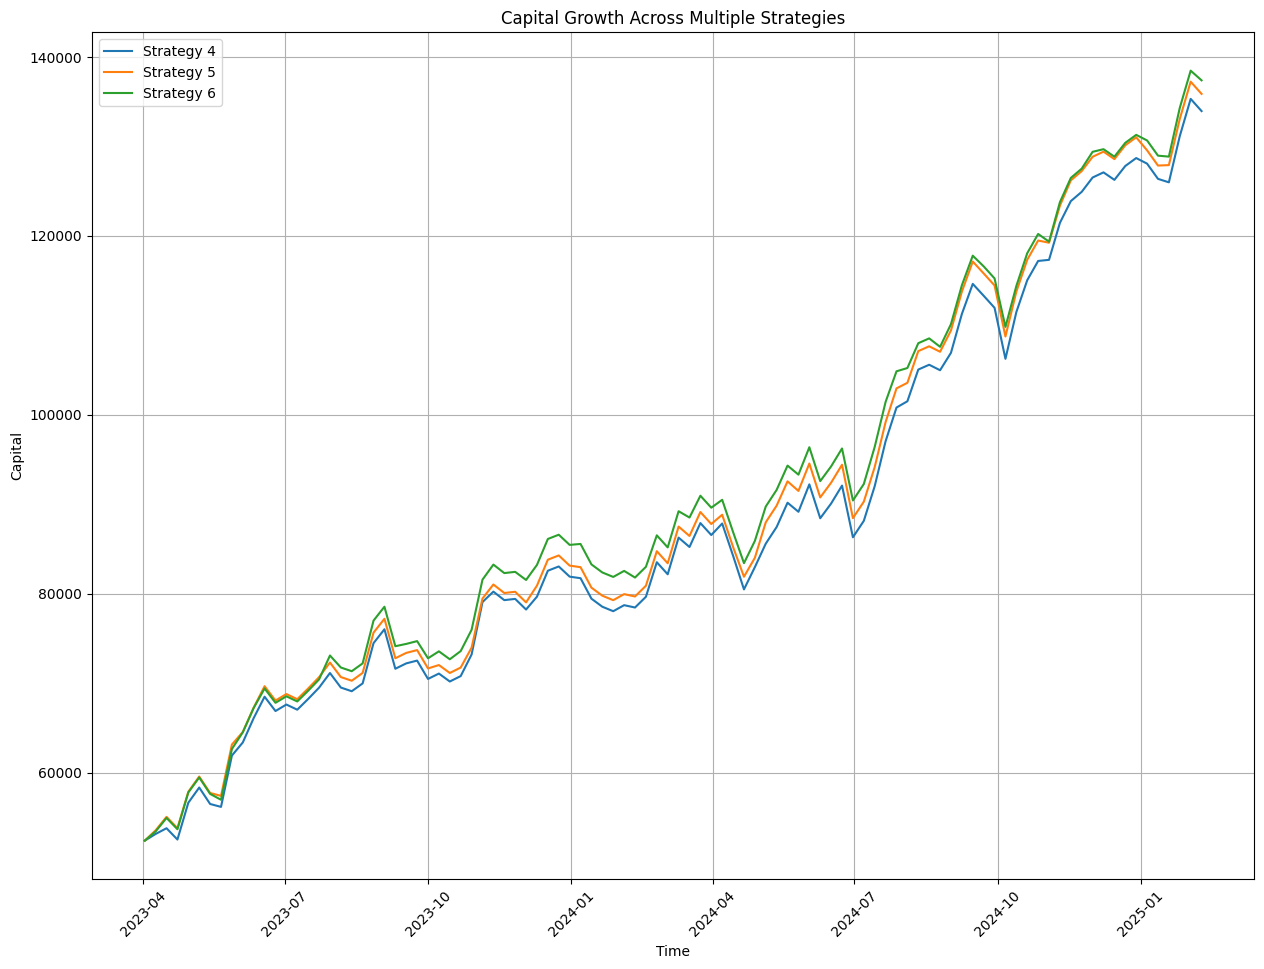

In [2]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+filepath,
                             plotAllDatas=False, dataIdsSelected=[4,5,6],
                             plotSize=(15,11))

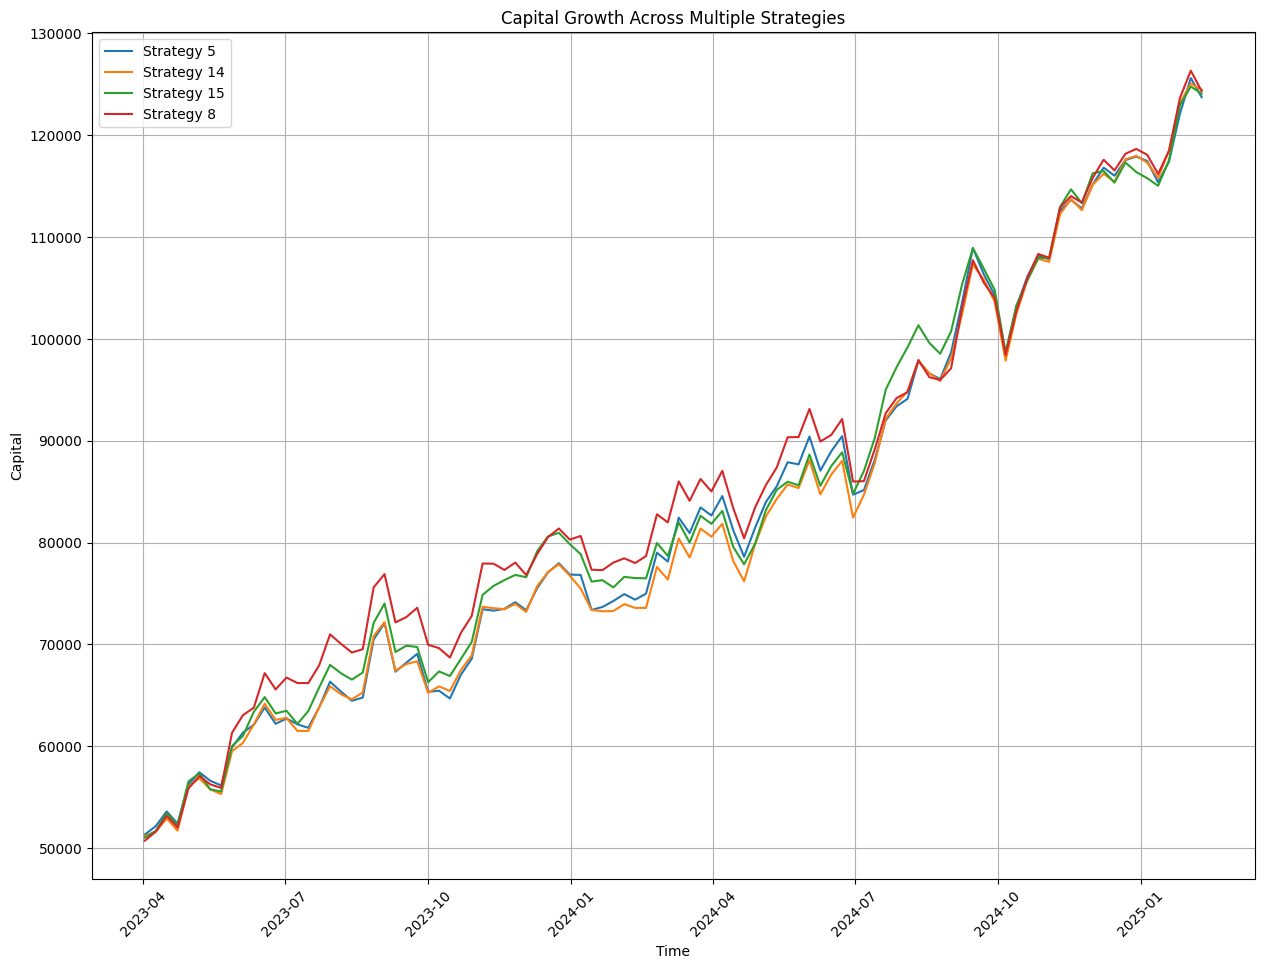

In [2]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+filepath,
                             plotAllDatas=False, dataIdsSelected=[5,14,15,8],
                             plotSize=(15,11))

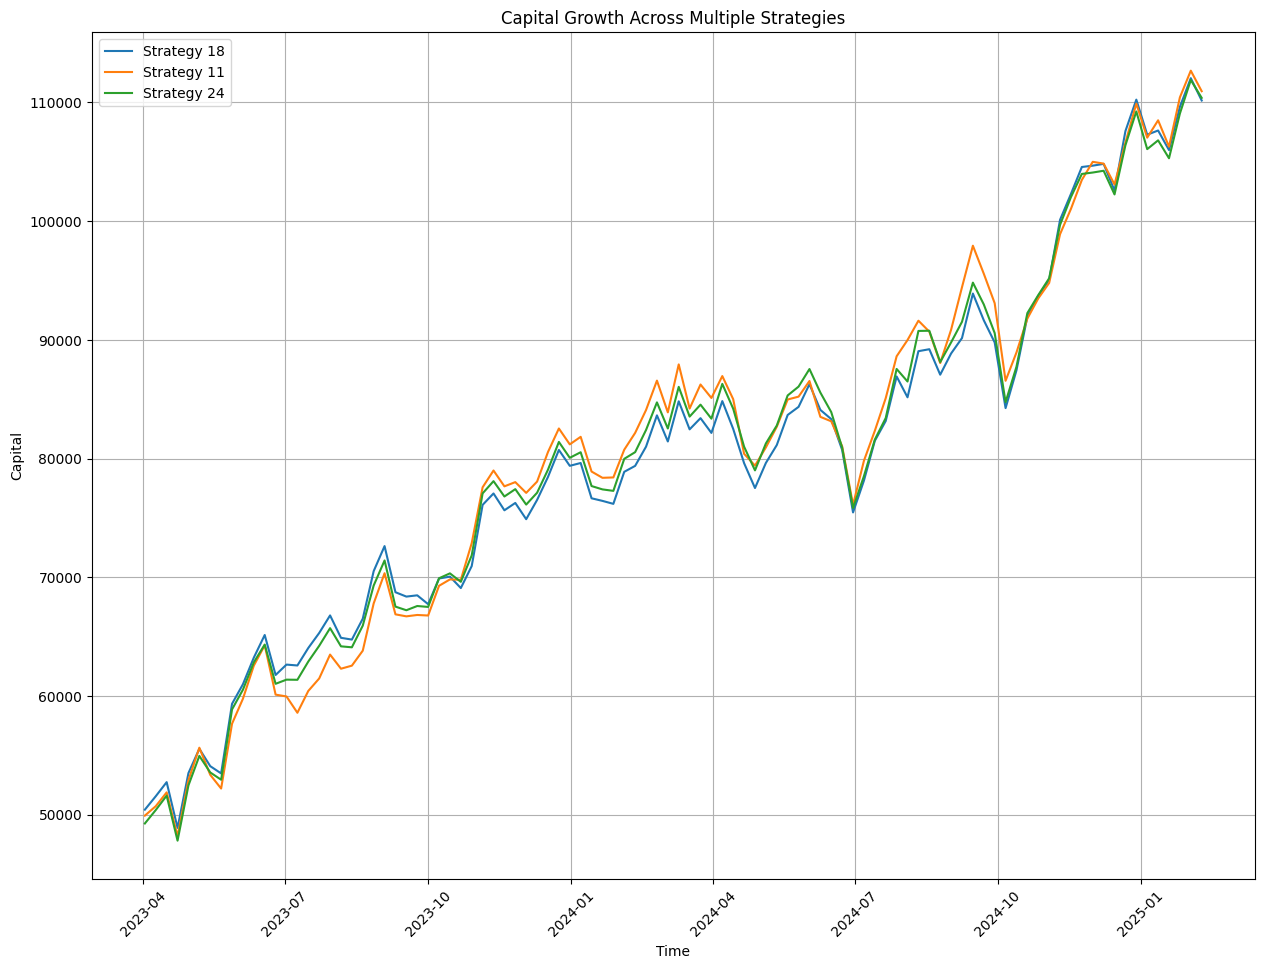

In [7]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+filepath,
                             plotAllDatas=False, dataIdsSelected=[18,11,24],
                             plotSize=(15,11))

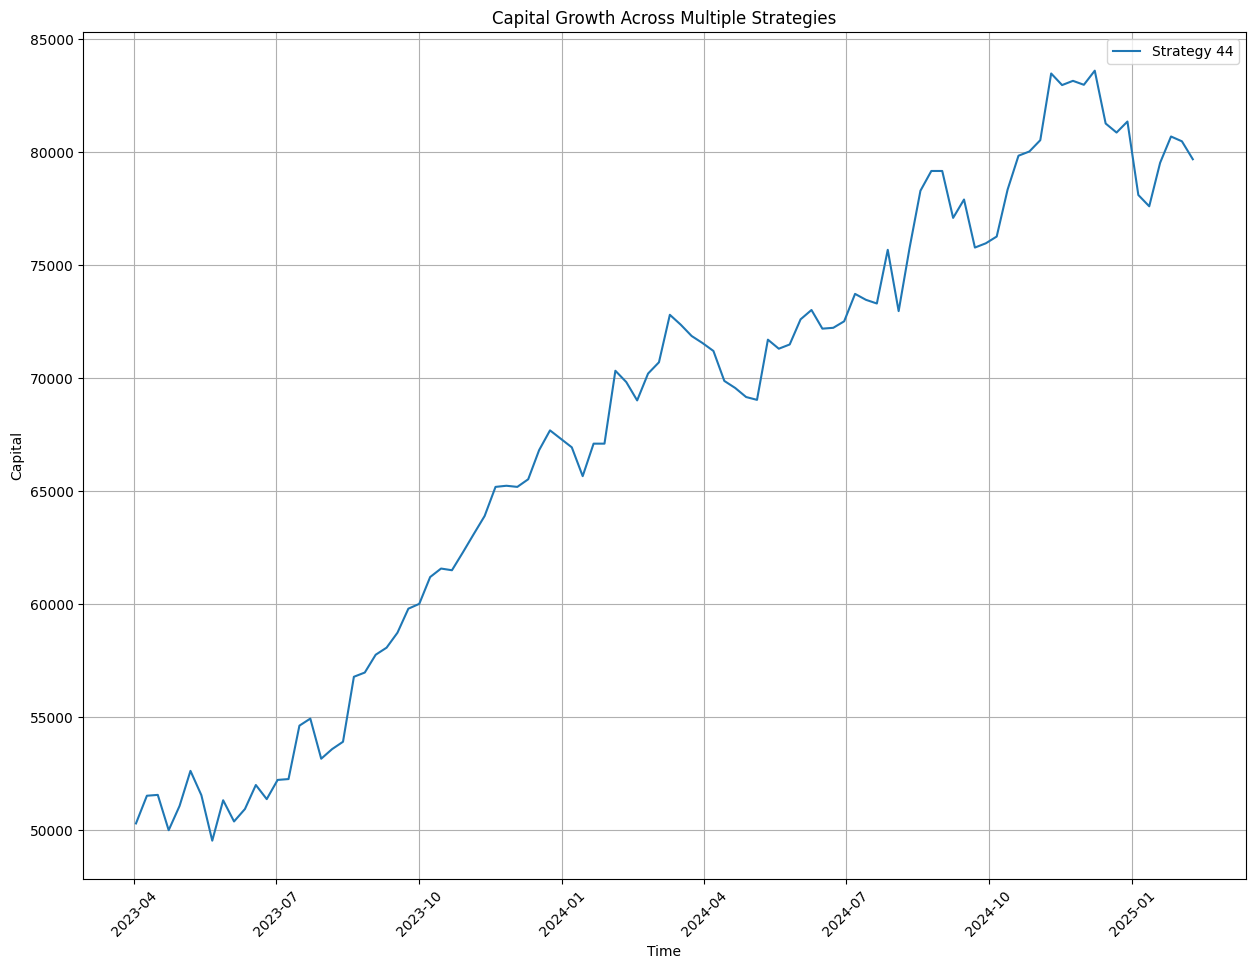

In [2]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+filepath,
                             plotAllDatas=False, dataIdsSelected=[44],
                             plotSize=(15,11))

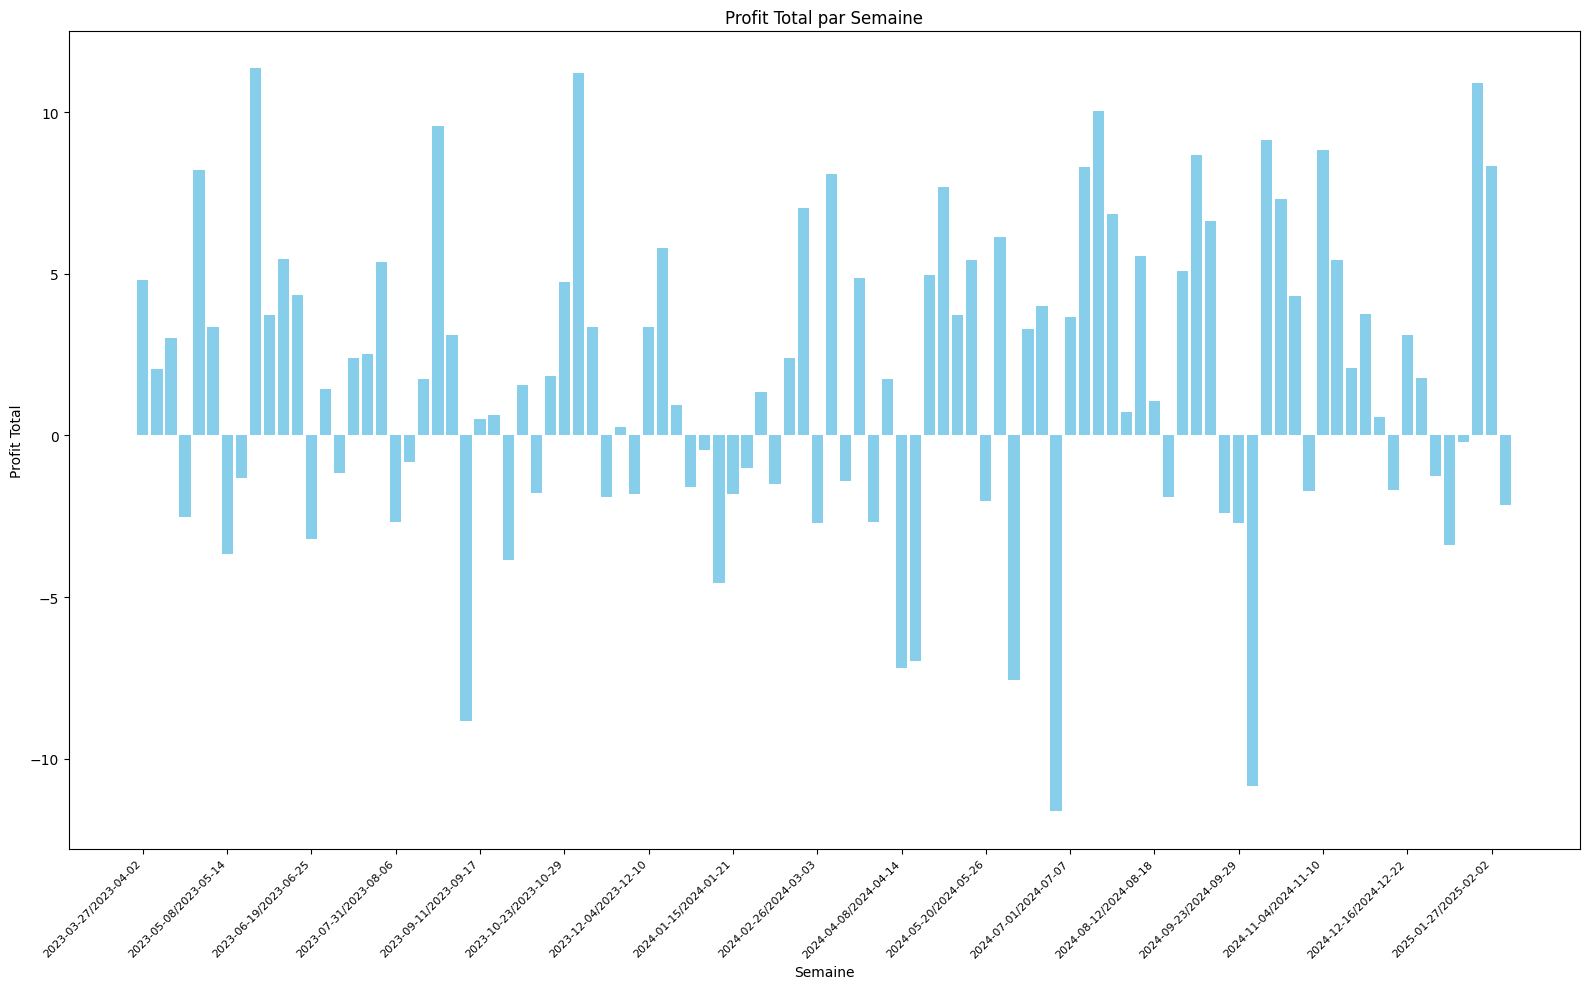

In [2]:
from processing_functions import plot_bars_of_profit_for_every_weeks
plot_bars_of_profit_for_every_weeks(filepath, 6)

Nouvelles choses à tester : 
- condition de sorties supp. si on a un grand doji/marteau/pendu (***) => fait! : résultats mauvais
- rajouter la possibilité de déplacer le TP si le profit continu. Peut etre avec la tenkan ou avec un autre indicateur? l'ATR? (***)
- stop loss suiveur avec tenkan? => méthode 4; retester avec les méthodes et sans slModifers(**) 
- restester sans niveau de pivot (**)
- rajouter une condition sur la taille de la bougie d'entrée = pas de trade si trop grande (**)
- tester d'augmenter la plage horraire de trading <7h ou >20h (**)
- analyser les heures les moins rentables = forbideenHours (**) 
- raffiner les niveaux de slModifiers/sl/tp (*)
- rajouter les niveaux du plus bas/plus haut journalier aux conditions d'entré (*)

choses à faire pour continuer à backtest : (déjà fait)
- avoir le temps moyen d'un trade avec la stratégie DTP : FAIT!
- regarder si le type de position (short ou long) a un impact sur le winrate
- continuer à améliorer la stratégie avec:
    - les autres conditions d'entrées de la strat DTP (ex: taille de la bougie)
    - des conditions sur les niveaux pivot
    - des conditions pour savoir si on est en range
    - faire en sorte que le tp/sl s'adapte à la distance au pivot
- calculer le profit réel en $ : FAIT!
- stop loss suiveur : passe en breakeven sous certaines conditions 
- condition sur l'entré en position avec le RSI : entrer seulement si dans la zone de hausse ou de baisse temperé 
- condition sur la taille de la bougie (bougie trop grande = news). On pourra utiliser les taille moyenne de bougie/H
- utilise l'API pour avoir l'historique des news

méthodes à tester maintenant :
- l'ATR défini notre niveau de TP (tester niveau de TP = atrRatio [2,3,4,5])
- la pente de l'ATR défini si on place un TP définitif, ex : si la pente de l'ATR < X et que prix actuel >= 90% TP initial on ne déplace plus le TP